## Gaussian Mixture Model clustering
Use the downloaded expression matrix + metadata to build a proportional subset, reduce dimensionality, and fit a GMM with the number of clusters matching the true subclasses.

In [2]:

from pathlib import Path
import os, sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import scanpy as sc

sys.path.append(str(Path.cwd()))
from data_utils import create_proportional_subset_h5ad


In [ ]:

# Paths and params
DATA_DIR = Path("data")
EXPR_H5 = DATA_DIR / "expression_matrix.hdf5"
META_CSV = DATA_DIR / "metadata.csv"
SUBSET_H5AD = DATA_DIR / "subset_expression.h5ad"
SUBSET_META = DATA_DIR / "subset_metadata.csv"

# Modeling params
MAX_CELLS = 5000
CELLTYPE_COL = "subclass_label"
RANDOM_STATE = 42
PCA_COMPONENTS = 50

EXPR_H5, META_CSV


(PosixPath('data/expression_matrix.hdf5'), PosixPath('data/metadata.csv'))

In [4]:

# Load metadata and compute number of clusters
meta = pd.read_csv(META_CSV)
labels = meta[CELLTYPE_COL].astype(str)
n_clusters = labels.nunique()
print(f"Metadata loaded: {meta.shape[0]:,} cells x {meta.shape[1]} columns")
print(f"Unique {CELLTYPE_COL}: {n_clusters}")


Metadata loaded: 1,169,213 cells x 57 columns
Unique subclass_label: 42


In [5]:

print("Creating proportional subset (this may take a few minutes)...")
create_proportional_subset_h5ad(
    expr_path=EXPR_H5,
    metadata_path=META_CSV,
    output_h5ad=SUBSET_H5AD,
    output_meta_csv=SUBSET_META,
    max_cells=MAX_CELLS,
    celltype_col=CELLTYPE_COL,
    min_prop=1e-3,
    random_state=RANDOM_STATE,
)


Creating proportional subset (this may take a few minutes)...
Expression matrix: 31,053 genes × 1,169,320 cells
Building sample name → index map...
Found 1169213 overlapping samples
Original proportions:
subclass_label
L4/5 IT CTX        0.236022
L6 CT CTX          0.127224
L2/3 IT CTX        0.109442
L6 IT CTX          0.066966
DG                 0.050417
L5 IT CTX          0.049769
L2/3 IT PPP        0.039750
Sst                0.038887
Vip                0.037362
Lamp5              0.036045
L5/6 NP CTX        0.027115
Pvalb              0.026053
Car3               0.019207
L6b/CT ENT         0.017336
L5 PT CTX          0.014762
CA1-ProS           0.013596
L6b CTX            0.012872
Sncg               0.011869
L3 IT ENT          0.011428
Oligo              0.007686
L2/3 IT ENTl       0.005502
CT SUB             0.004934
L5/6 IT TPE-ENT    0.004917
L4 RSP-ACA         0.003928
L2 IT ENTl         0.003907
SUB-ProS           0.003581
Astro              0.003335
L2/3 IT RHP        0.0026

100%|██████████| 5/5 [05:51<00:00, 70.35s/it]


Saved: data/subset_expression.h5ad (shape (4988, 31053))
Saved: data/subset_metadata.csv (shape (4988, 56))


AnnData object with n_obs × n_vars = 4988 × 31053
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [6]:

# Load subset
adata = sc.read_h5ad(SUBSET_H5AD)
adata.obs[CELLTYPE_COL] = adata.obs[CELLTYPE_COL].astype(str)
print(adata)
print(adata.obs[CELLTYPE_COL])
print("New unique labels:", adata.obs[CELLTYPE_COL].nunique())
n_clusters = adata.obs[CELLTYPE_COL].nunique()



AnnData object with n_obs × n_vars = 4988 × 31053
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [7]:

# Prepare features: log1p, scale, PCA
import data_preprocess as dp
adata_preproc = dp.preprocess(adata.copy())
X_scaled = adata_preproc.X
if hasattr(X_scaled, "toarray"):
    X_scaled = X_scaled.toarray()
X_scaled = np.asarray(X_scaled, dtype=np.float32)

print(f"X scaled shape: {X_scaled.shape}")


Finished preprocessing: 4988 cells x 2000 HVGs
X scaled shape: (4988, 2000)


In [21]:

# Fit GMM and evaluate against true labels
true_labels = adata.obs[CELLTYPE_COL].to_numpy()
print("True labels:", true_labels)
print("Num components for GMM:", n_clusters)
gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type="diag",
    max_iter=300,
    init_params="kmeans",
)
pred_labels = gmm.fit_predict(X_scaled)

ari = metrics.adjusted_rand_score(true_labels, pred_labels)
nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
hom = metrics.homogeneity_score(true_labels, pred_labels)
comp = metrics.completeness_score(true_labels, pred_labels)

sil = None
try:
    sil = metrics.silhouette_score(
        X_scaled, pred_labels, sample_size=min(2000, len(pred_labels)), random_state=RANDOM_STATE
    )
except Exception as e:
    print(f"Silhouette not computed: {e}")

print(f"GMM metrics (n_clusters={n_clusters}):")
print(f"  ARI: {ari:.4f}")
print(f"  NMI: {nmi:.4f}")
print(f"  Homogeneity: {hom:.4f}")
print(f"  Completeness: {comp:.4f}")
if sil is not None:
    print(f"  Silhouette (on PCA space): {sil:.4f}")

# Cluster size sanity check
print("Predicted cluster sizes:")
print(pd.Series(pred_labels).value_counts().sort_index())


True labels: ['L4/5 IT CTX' 'L4/5 IT CTX' 'L4/5 IT CTX' ... 'L5 PPP' 'L5 PPP' 'L5 PPP']
Num components for GMM: 35
GMM metrics (n_clusters=35):
  ARI: 0.0240
  NMI: 0.1242
  Homogeneity: 0.1319
  Completeness: 0.1173
  Silhouette (on PCA space): -0.0085
Predicted cluster sizes:
0       1
1       1
2     160
3     346
4     182
5     180
6     214
7     208
8     277
9       3
10    186
11      1
12     81
13     81
14    241
15    538
16      8
17    256
18      8
19     70
20     78
21    436
22     15
23      1
24    114
25     16
26     15
27     49
28    316
29      5
30    269
31    233
32     85
33    235
34     79
Name: count, dtype: int64


/tmp/ipykernel_39670/3545921570.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(true_categories), pred_labels.max() + 1))


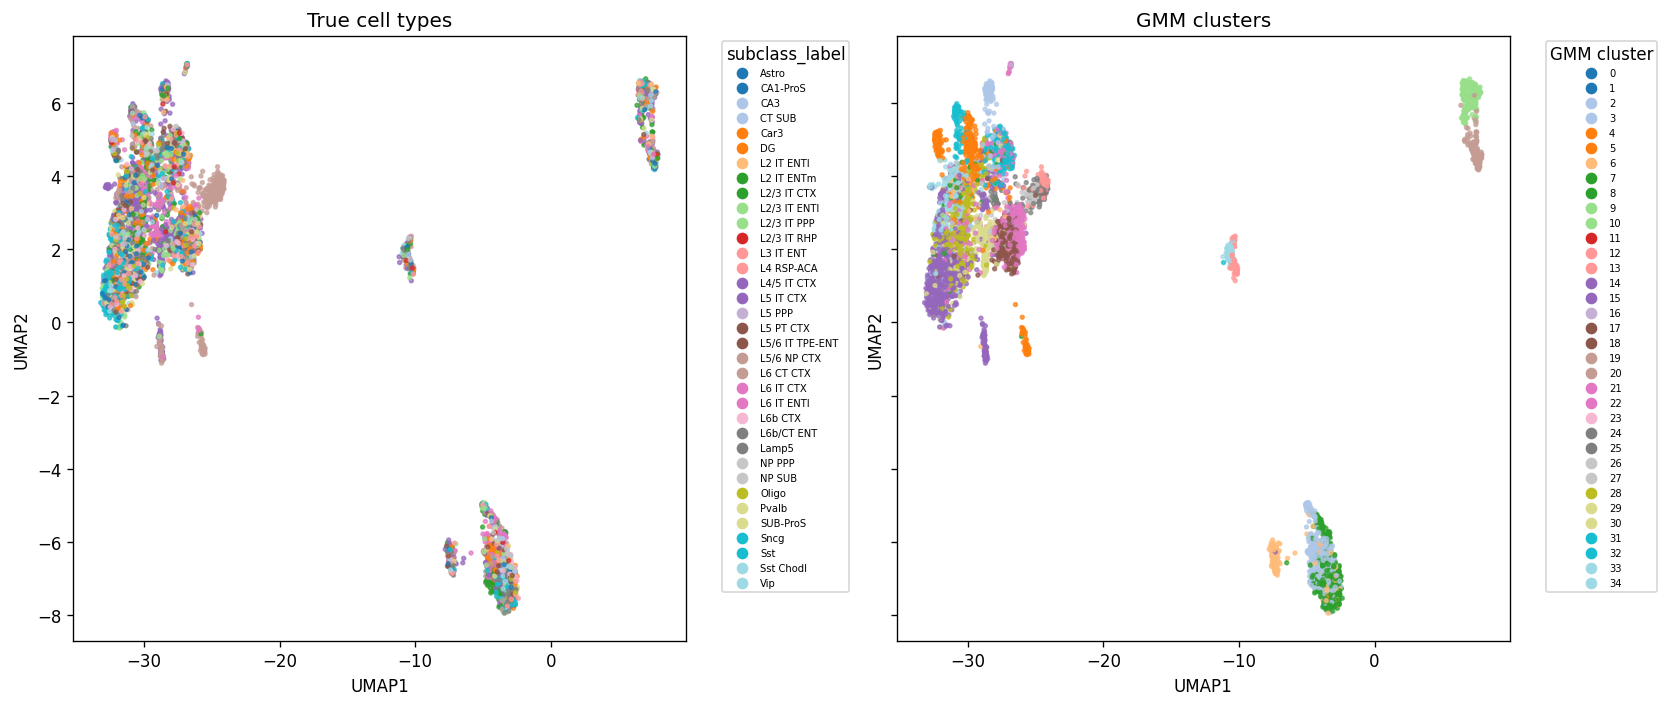

In [22]:
# Visualize true vs GMM clusters on UMAP of PCA features
import matplotlib.pyplot as plt
from umap import UMAP

umap = UMAP(n_components=2, min_dist=0.3, n_neighbors=15)
X_umap = umap.fit_transform(X_scaled)

cat = pd.Categorical(adata.obs[CELLTYPE_COL])
true_codes = cat.codes
true_categories = cat.categories

fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=120, sharex=True, sharey=True)
cmap = plt.cm.get_cmap("tab20", max(len(true_categories), pred_labels.max() + 1))

sc0 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=true_codes, s=5, cmap=cmap, alpha=0.7)
axs[0].set_title("True cell types")

sc1 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=pred_labels, s=5, cmap=cmap, alpha=0.7)
axs[1].set_title("GMM clusters")

for ax in axs:
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

handles_true = [plt.Line2D([0], [0], marker='o', linestyle='', color=cmap(i), label=lab) for i, lab in enumerate(true_categories)]
axs[0].legend(handles=handles_true, title=CELLTYPE_COL, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=6)

handles_pred = [plt.Line2D([0], [0], marker='o', linestyle='', color=cmap(i), label=str(i)) for i in range(pred_labels.max() + 1)]
axs[1].legend(handles=handles_pred, title="GMM cluster", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=6)

plt.tight_layout()
plt.show()


NMI (noisy data): 0.1448
ARI (noisy data): 0.0313
Predicted cluster sizes (noisy data):
0      11
1      78
2     200
3      11
4      23
5      72
6     160
7     220
8     467
9     185
10     11
11     60
12     15
13    122
14    196
15    171
16    388
17     62
18      2
19     72
20    357
21    401
22    131
23    246
24    544
25    130
26     17
27    136
28     98
29     98
30     59
31     95
32      1
33    126
34     23
Name: count, dtype: int64


/home/ryanghosh/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_39670/2296623745.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_noise = plt.cm.get_cmap("tab20", max(len(true_categories), pred_noisy.max() + 1))


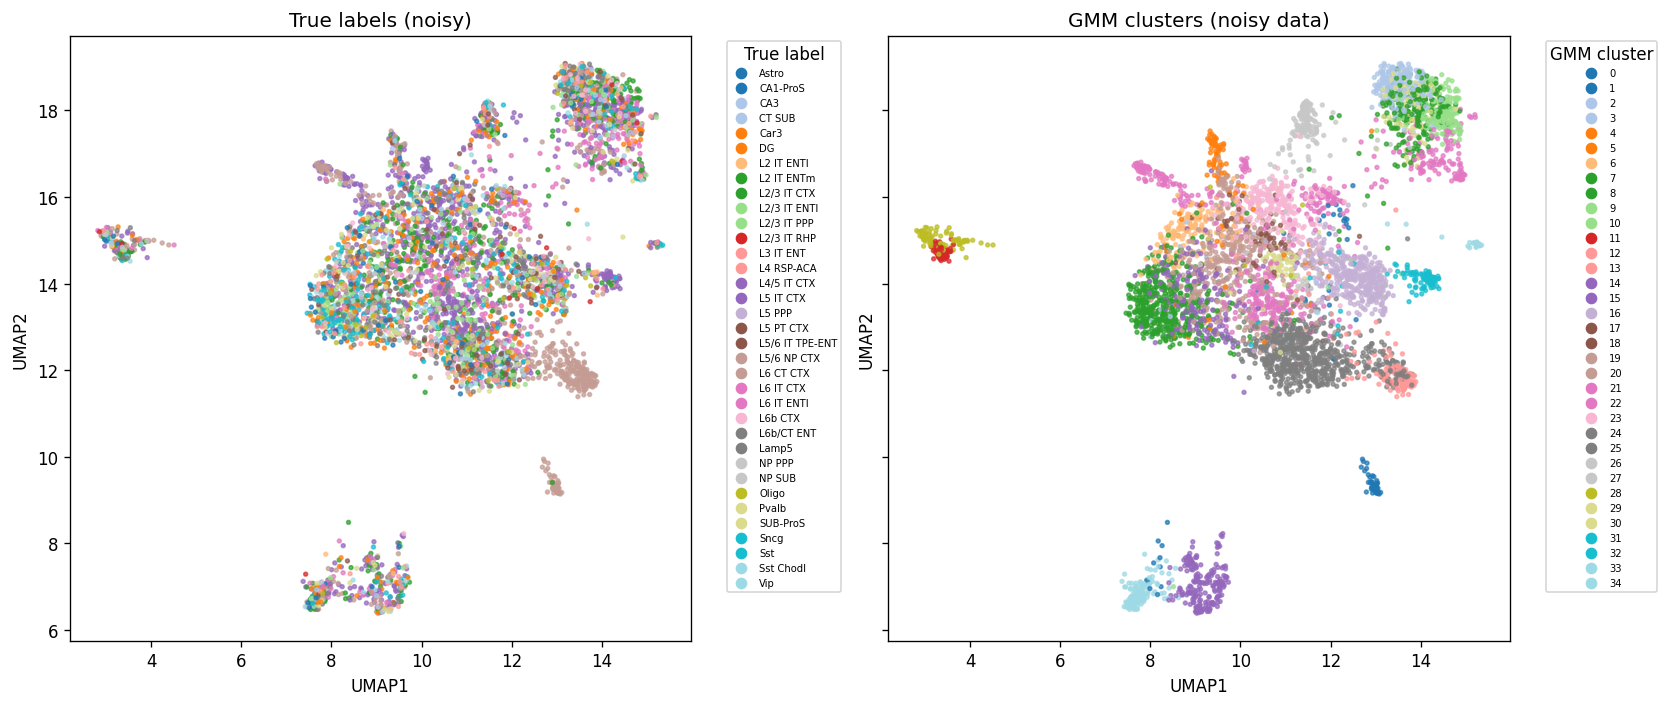

In [23]:
# GMM on data with additive Gaussian noise (mean=1, var=1)
noise = np.random.normal(loc=1.0, scale=1.0, size=X_scaled.shape)
X_noisy = X_scaled + noise

gmm_noise = GaussianMixture(
    n_components=n_clusters,
    covariance_type="diag",
    max_iter=300,
    init_params="kmeans",
    reg_covar=1e-3,
)
pred_noisy = gmm_noise.fit_predict(X_noisy)

nmi_noisy = metrics.normalized_mutual_info_score(true_labels, pred_noisy)
ari_noisy = metrics.adjusted_rand_score(true_labels, pred_noisy)
print(f'NMI (noisy data): {nmi_noisy:.4f}')
print(f'ARI (noisy data): {ari_noisy:.4f}')
print('Predicted cluster sizes (noisy data):')
print(pd.Series(pred_noisy).value_counts().sort_index())

# UMAP visualization for noisy data
umap_noise = UMAP(n_components=2, random_state=RANDOM_STATE, min_dist=0.3, n_neighbors=15)
X_umap_noise = umap_noise.fit_transform(X_noisy)

true_cat = pd.Categorical(true_labels)
true_codes = true_cat.codes
true_categories = true_cat.categories

fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=120, sharex=True, sharey=True)
cmap_noise = plt.cm.get_cmap("tab20", max(len(true_categories), pred_noisy.max() + 1))

axs[0].scatter(X_umap_noise[:, 0], X_umap_noise[:, 1], c=true_codes, s=5, cmap=cmap_noise, alpha=0.7)
axs[0].set_title('True labels (noisy)')
axs[0].set_xlabel('UMAP1')
axs[0].set_ylabel('UMAP2')

axs[1].scatter(X_umap_noise[:, 0], X_umap_noise[:, 1], c=pred_noisy, s=5, cmap=cmap_noise, alpha=0.7)
axs[1].set_title('GMM clusters (noisy data)')
axs[1].set_xlabel('UMAP1')
axs[1].set_ylabel('UMAP2')

handles_true = [plt.Line2D([0], [0], marker='o', linestyle='', color=cmap_noise(i), label=lab) for i, lab in enumerate(true_categories)]
axs[0].legend(handles=handles_true, title='True label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)

handles_pred = [plt.Line2D([0], [0], marker='o', linestyle='', color=cmap_noise(i), label=str(i)) for i in range(pred_noisy.max() + 1)]
axs[1].legend(handles=handles_pred, title='GMM cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)

plt.tight_layout()
plt.show()
